# CAB420 Assignment 1B Question 2: Template

## Overview

This notebook provides a helper function to load in the Oxford-IIIT Pets dataset suitable for classification and semantic segmentation.

It also provides an example of how to load in the MobileNetV3Small Network which you are required to fine tune for the second part of the question.

Please read the comments and instructions within this notebook. It has been carefully designed to help you with many of the tasks required.

In [28]:
# !pip install tensorflow==2.11
# import tensorflow as tf
# print(tf.__version__)
# !pip install --upgrade protobuf

In [1]:

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
# !pip install tensorflow_addons
import tensorflow_addons as tfa
import tensorflow.keras.layers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, SpatialDropout2D, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import models


import numpy as np
import pandas as pd
# !pip install tensorflow_datasets
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
import glob
import seaborn as sns
from sklearn.metrics import classification_report, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay

2.11.0


/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Loading in the data

We first provide some helper functions to format the data in the way we need. You shouldn't need to change these, though you are welcome to if you like.


In [2]:
def preprocess_segmentation_mask(segmentation_mask):
    """preprocess the semgentation mask

    The original segmentation mask has three categories.
      foreground, background and outline
    This function will just convert it to foreground and background 

    The original segmentation mask is also 1-index, so will convert it
    to 0-index.

    the original mask is represented as:
    1 - edge of dog/cat and things like leashes etc.
    2 - background
    3 - foreground

    we want to just keep the merge the edges and foreground of the doggo/catto, and
    then treat it as a binary semantic segmentation task.
    To achieve this, we will just subtract two, converting to values of [-1, 0, 1],
    and then apply the abs function to convert the -1 values (edges) to the foreground.

    Will also convert it to 32 bit float which will be needed for working with tf.
    
    Why am I doing it this way?
     A reasonable question. Initially I tried to do it with just normal array indexing,
     but this is a bit more work since the mask is a tensorflow tensor and not a np array.
     We could alternatively convert it to an array, perform indexing and then map it back,
     but this would have a performance overhead, which wouldn't be a big deal, but still.
     With all that being said, I am doing it for you, so you don't have to.

    Args:
      segmentation_mask (array):
        original segmentation mask

    Returns:
      preprocessed segmentation_mask
    """
    return tf.abs(tf.cast(segmentation_mask, tf.float32) - 2)

def return_image_label_mask(ds_out):
    """ function to return image, class label and segmentation mask

    The original dataset contains additional information, such as the filename and
    the species. We don't care about any of that for this work, so will
    discard them and just keep the original image as our input, and then
    a tuple of our outputs that will be the class label and the semantic
    segmentation mask.

    Whilst we are here, we will also preprocess the segmentation mask.

    Args:
      ds_out: dict
        original dataset output

    Returns:
       RGB image
       tuple of class label and preprocessed segmentation mask
    """
    # preprocess the segmentation mask
    seg_mask =  preprocess_segmentation_mask(ds_out['segmentation_mask'])
    image = tf.cast(ds_out['image'], tf.float32)
    # image = standardise_image(image)
    return image, (ds_out['label'], seg_mask)

In [3]:
def mobilenet_preprocess_image(image):
    """Apply preprocessing that is suitable for MobileNetV3.
    
    Simply scales to ranges [-1, 1]
    
    
    you should use this preprocessing for both your model and the mobilenet model
    """
    image = (image - 127.5) / 255.0
    return image
    
    
def unprocess_image(image):
    """ undo preprocessing above so can plot images"""
    image = image * 255.0 + 127.5
    return image

In [4]:

def preprocess_and_resize(image, output, image_size):
    """apply preprocessing steps above to images and resize images and maps
    
    Each image in the dataset is of a different size. The resizing will make sure
    each image is the same size.
    """
    # resize the image and the semantic segmentation mask
    image = tf.image.resize(image, [image_size, image_size])
    image = mobilenet_preprocess_image(image)
    mask = tf.image.resize(output[1], [image_size, image_size])
    return image, (output[0], mask)


We will now put this all together into a helper function. You can use this directly as is and should be fine to hit the ground running. However, you may modify it to add some additional functionality such as data augmentation if you like.

In [5]:
# putting it all together into one big helper function

def load_oxford_pets(split,
                     batch_size=233,
                     shuffle=True,
                     image_size=300):
    """Load Oxford pets dataset for Assignment 1B

    Function handles loading of data for 1b, included processing of images and
    semantic segmentation masks. This function will
    organise the tensorflow dataset to return an output that is a tuple, where
    the tuple will be (classification_labels, segmentation_masks).

    Parameters
    ----------
    split : string
        either train or test string
    classification : bool
        whether to include classification labels
    segmentation : bool
        whether to include semantic segmentation masks
    batch_size : int
        size of batches to use
    shuffle : bool
        whether to shuffle the dataset (WILL ONLY APPLY TO TRAIN)
    image_size : int
        new image size

    Returns
    -------
       tf.Dataset containing the Oxford pets dataset
    """
    # lets do some error checking first
    if (split != 'train') and (split != 'test'):
        raise ValueError('Arg for split must be either \'train\' or \'test\'')
    if (split == 'test') and shuffle:
        print("WARNING: shuffle is set to true, but have specified split to be \'test\'")
        print('The shuffle argument will be ignored')
        shuffle = False
   
    # now start loading the dataset
    ds = tfds.load('oxford_iiit_pet',
                   split=split,
                   with_info=False)
    # remove unnecessary dataset info
    ds = ds.map(return_image_label_mask)

    # HINT: looks like a comfy spot for where some data augmentation might want to live ;)
    
    
    # Final processing of the data 
    # here we will resize the data, and add the preprocessing that is needed 
    # and compatable with the mobilenet models.
    ds = ds.map(lambda inp, out: preprocess_and_resize(inp, out, image_size))

    if split == 'train' and shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
                 

## Testing the provided data loader.

Let's test it all and plot some examples to make sure they are working. I have provided some bad defaults for the image size and the batch size.

**YOU WILL NEED TO CHANGE THESE**, unless you have access to multiple A100 GPUS for some reason.

In [6]:
# testing it and plotting some images.
# NOTE: the image size I am setting here is all but definitely too large. You will need
# to chage this yourself to something that is suitable given your constraints
# NOTE: The batch size is also too large. I am doing this on purpose to force you to 
# pick a suitable batch size yourself
image_size = 256 # Keep images to 120 by 120
batch_size = 100
train_class_seg = load_oxford_pets('train', shuffle=True, batch_size=batch_size, image_size=image_size)
test_class_seg = load_oxford_pets('test', shuffle=False, batch_size=batch_size, image_size=image_size)

# pull the labels out 
train_class_seg_ns = load_oxford_pets('train', shuffle=False, batch_size=batch_size, image_size=image_size)
y_class = np.concatenate([y[0] for x, y in train_class_seg_ns.as_numpy_iterator()])
y_seg = np.concatenate([y[0] for x, y in train_class_seg_ns.as_numpy_iterator()])

print(y_class.shape)
print(y_seg.shape)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(3680,)
(3680,)


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


(100, 256, 256, 1)
(100, 256, 256, 1)
(100, 256, 256, 1)


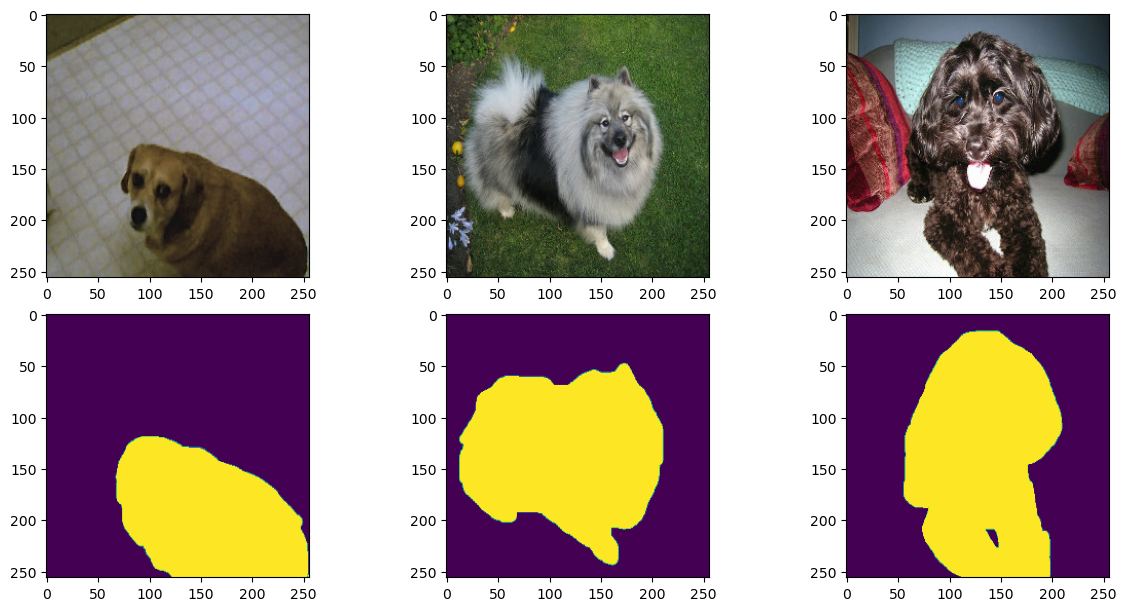

In [7]:
# lets plot a few now to see some good kittens/doggos
fig, axs = plt.subplots(2, 3, figsize=(12, 6), layout="constrained")
num_plot = 3
i = 0
# each sample of our dataset will be of the format
# image, outputs
# where outputs[0] = label
#       outputs[1] = segmentation mask
#
#
# lets get a single batch, and plot just a few of them
for image, output in train_class_seg.take(1).as_numpy_iterator(): 
    for i in range(num_plot): 
        im = axs[0, i].imshow(np.squeeze(unprocess_image(image[i, ...])) / 255.0)
        im = axs[1, i].imshow(np.squeeze(output[1][i, ...]))
        print(output[1].shape)
        i += 1
        if i >= num_plot:
            break
        
plt.savefig('doggos_cattos.png')


Looks good, can ignore the JPEG data Warning.

# Loading MobileNetV3Small base for fine tuning

This model can be loaded directly from Tensorflow. By default, the model we download will be pre-trained on Imagenet dataset.

Note that we will need to set the preprocessing option when loading this base network to False.
    This is because the `include_preprocessing` step is implemented in the Datasets we defined above.

We also set `include_top=False`, to avoid loading our model with the final Dense classification layer which is used for the original Imagenet model.

Model: "mobilenet_fine_tune"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 MobilenetV3small (Functional)  (None, 8, 8, 576)    939120      ['input_7[0][0]']                
                                                                                                  
 up_sampling2d_6 (UpSampling2D)  (None, 24, 24, 576)  0          ['MobilenetV3small[0][0]']       
                                                                                                  
 conv2d_21 (Conv2D)             (None, 24, 24, 64)   331840      ['up_sampling2d

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 102s 3s/step - loss: 2.1503 - classification_loss: 1.8731 - resizing_2_loss: 0.2772 - val_loss: 5.5469 - val_classification_loss: 5.2950 - val_resizing_2_loss: 0.2519
Epoch 2/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 99s 3s/step - loss: 0.6294 - classification_loss: 0.4755 - resizing_2_loss: 0.1539 - val_loss: 2.9542 - val_classification_loss: 2.7185 - val_resizing_2_loss: 0.2357
Epoch 3/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 97s 3s/step - loss: 0.3168 - classification_loss: 0.1887 - resizing_2_loss: 0.1281 - val_loss: 3.0550 - val_classification_loss: 2.8274 - val_resizing_2_loss: 0.2276
Epoch 4/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 96s 3s/step - loss: 0.1941 - classification_loss: 0.0789 - resizing_2_loss: 0.1151 - val_loss: 2.7824 - val_classification_loss: 2.5620 - val_resizing_2_loss: 0.2204
Epoch 5/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 96s 3s/step - loss: 0.1480 - classification_loss: 0.0421 - resizing_2_loss: 0.1059 - val_loss: 2.7825 - val_classification_loss: 2.5704 - val_resizing_2_loss: 0.2121
Epoch 6/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 96s 3s/step - loss: 0.1380 - classification_loss: 0.0376 - resizing_2_loss: 0.1004 - val_loss: 3.0193 - val_classification_loss: 2.7969 - val_resizing_2_loss: 0.2223
Epoch 7/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 96s 3s/step - loss: 0.1465 - classification_loss: 0.0434 - resizing_2_loss: 0.1031 - val_loss: 2.7484 - val_classification_loss: 2.5491 - val_resizing_2_loss: 0.1994
Epoch 8/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 98s 3s/step - loss: 0.1591 - classification_loss: 0.0635 - resizing_2_loss: 0.0956 - val_loss: 2.2752 - val_classification_loss: 2.0671 - val_resizing_2_loss: 0.2081
Epoch 9/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 99s 3s/step - loss: 0.1590 - classification_loss: 0.0657 - resizing_2_loss: 0.0933 - val_loss: 2.8312 - val_classification_loss: 2.6387 - val_resizing_2_loss: 0.1925
Epoch 10/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 99s 3s/step - loss: 0.1523 - classification_loss: 0.0587 - resizing_2_loss: 0.0936 - val_loss: 3.8671 - val_classification_loss: 3.6574 - val_resizing_2_loss: 0.2097
Epoch 11/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 99s 3s/step - loss: 0.1614 - classification_loss: 0.0668 - resizing_2_loss: 0.0946 - val_loss: 3.9896 - val_classification_loss: 3.8013 - val_resizing_2_loss: 0.1883
Epoch 12/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 98s 3s/step - loss: 0.1449 - classification_loss: 0.0536 - resizing_2_loss: 0.0913 - val_loss: 3.2585 - val_classification_loss: 3.0815 - val_resizing_2_loss: 0.1770
Epoch 13/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 98s 3s/step - loss: 0.1328 - classification_loss: 0.0432 - resizing_2_loss: 0.0896 - val_loss: 3.8127 - val_classification_loss: 3.6336 - val_resizing_2_loss: 0.1791
Epoch 14/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 98s 3s/step - loss: 0.1553 - classification_loss: 0.0695 - resizing_2_loss: 0.0858 - val_loss: 5.5803 - val_classification_loss: 5.3834 - val_resizing_2_loss: 0.1969
Epoch 15/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 98s 3s/step - loss: 0.1522 - classification_loss: 0.0647 - resizing_2_loss: 0.0875 - val_loss: 4.2235 - val_classification_loss: 4.0515 - val_resizing_2_loss: 0.1721


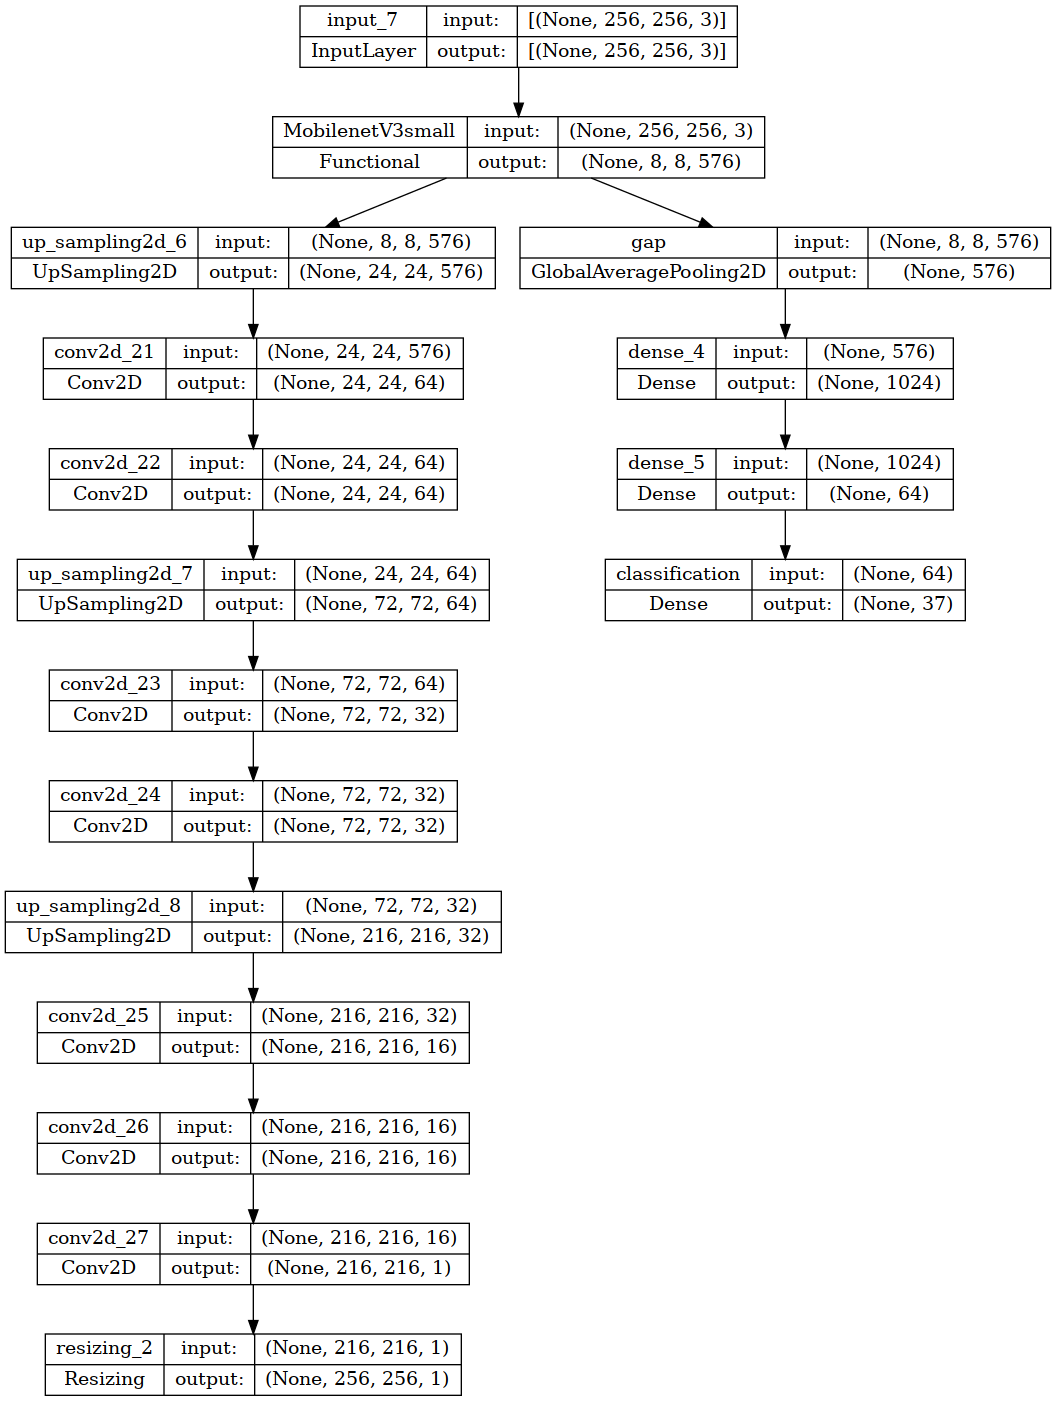

In [36]:
# 128 is the current image size 
# 3 channels

################################
# BACKBONE
################################

# changed input shape's 3rd dimension from 3 to 1
# include_top=False no classification 
# inputs = keras.Input(shape=(128, 128, 3, ), name='img')
inputs = keras.layers.Input((image_size, image_size, 3))

mobile_base = keras.applications.MobileNetV3Small(input_shape=(image_size, image_size, 3),
                                                  include_top=False,
                                                  include_preprocessing=False)

# setting up base network / encoder to get embedding
inputs = layers.Input((image_size, image_size, 3))
embedding = mobile_base(inputs)

################################
# END OF BACKBONE
################################
end_of_backbone = mobile_base.output


################################
# CLASSIFICATION HEAD
################################

# flatten layer
# x = layers.Flatten()(end_of_backbone)
# # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
# # in the middle
# x = layers.Dense(256, activation='relu')(x)
# # x = layers.Dropout(0.5)(x)
# 
# # the output
# class_output = layers.Dense(37, activation='softmax')(x)

# use one hot representation for the classification task use sparse_categorical_crossentropy
# model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='model q2')
# model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='model q2')
# x = layers.Flatten()(end_of_backbone)
# x = keras.layers.GlobalAveragePooling2D()(end_of_backbone)

# # add a fully-connected layer
# 

# and a logistic layer
# class_output = keras.layers.Dense(37, activation='sigmoid')(x)

# x = keras.layers.GlobalAveragePooling2D()(end_of_backbone)

# # add a fully-connected layer
# x = keras.layers.Dense(1024, activation='relu')(x)

# and a logistic layer
# predictions = keras.layers.Dense(37, activation='softmax')(x)


# embedding_size = 32
# embedding = mobile_base(inputs)
# flattened = layers.MaxPool2D(name='gap')(embedding)
# flat_2 = layers.Flatten()(flattened)
# predictions = layers.Dense(37, activation='softmax')(flat_2)
# model_test = keras.Model(inputs=inputs, outputs=predictions, name='mobile_net_fine_tune')

# model_test.summary()
# model_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # fit the model



# classification output
flattened = layers.GlobalAveragePooling2D(name='gap')(embedding)
x = keras.layers.Dense(1024, activation='relu')(flattened)
x = keras.layers.Dense(64, activation='relu')(x)
classification = layers.Dense(37, activation=None, name='classification')(x)


################################
# SEGMENTATION HEAD
################################

# # decoder
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(end_of_backbone)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x) # values between 0 or 1  by this 

# # use binary cross entropy for the segmentation task
# model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='mobile_net_fine_tune')
# model_cnn.summary()
# model_cnn.compile(optimizer='adam', loss=['categorical_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])

# # fit the model
# history = model_cnn.fit(train_class_seg, epochs=10, validation_data=test_class_seg)

# triplet loss and segmentation loss
# auto encoder and metric learning tasks
#  -> we did not set up as classification and segmentation loss



# decoder
x =  layers.UpSampling2D((3, 3))(embedding)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# output, 3 channels
x =  layers.Conv2D(1, (1, 1), activation=None, padding='same')(x)
decoded = keras.layers.Resizing(image_size, image_size)(x)







model_test = keras.Model(inputs, outputs=[classification, decoded] , name='mobilenet_fine_tune')

model_test.summary()
keras.utils.plot_model(model_test, show_shapes=True)

model_test.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   keras.losses.MeanAbsoluteError()],
              optimizer='adam')

history = model_test.fit(train_class_seg,
          epochs=15,
          validation_data=test_class_seg,
          verbose=True)



# history = model_test.fit(train_class_seg, epochs=10,batch_size=100, validation_data=test_class_seg)

# mobile_base = keras.applications.MobileNetV3Small(inputs,
#                                                   include_top=False,
#                                                   include_preprocessing=False)

# # add a global spatial average pooling layer
# x = mobile_base.output



keras.utils.plot_model(model_test, show_shapes=True)

For this task, can ignore the input_shape warning, though it is important to keep in mind the difference in size of data used for the pre-trained model and our data may have an impact on our model (what that impact might be is for you to investigate :) )

For more information on fine-tuning models, can refer to many of the examples from class, or the Keras documentation.

https://keras.io/guides/transfer_learning/


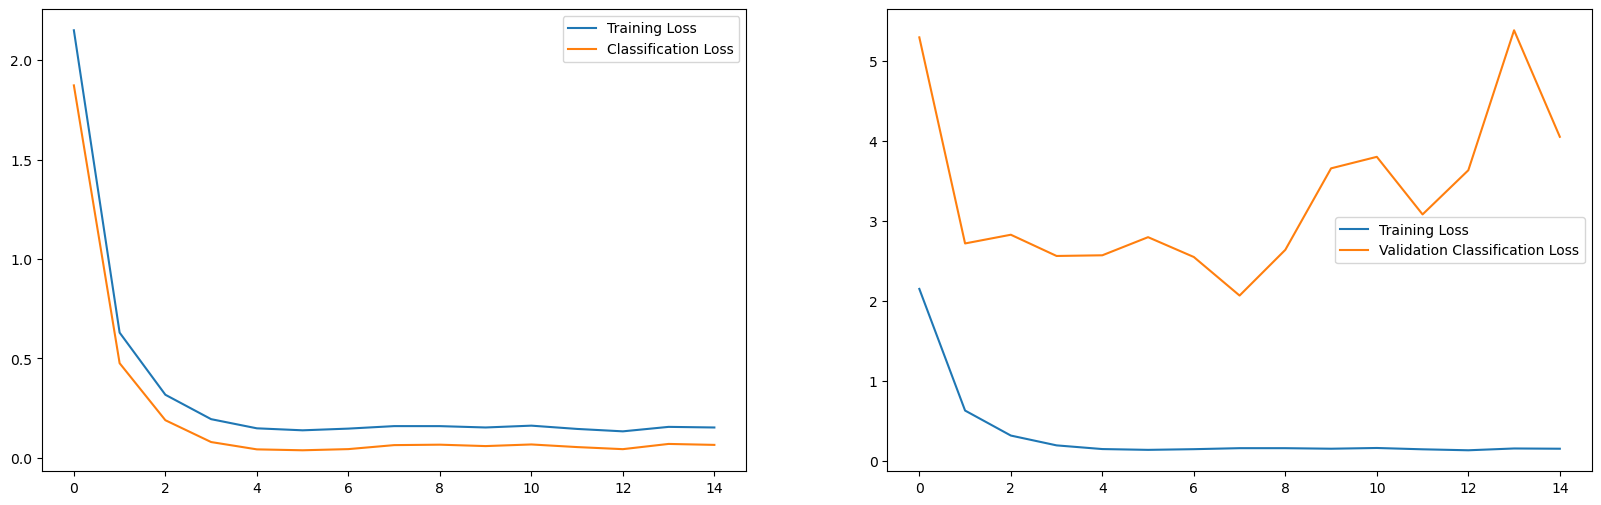

In [37]:
# plot training and validation loss and accuracy
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['classification_loss'], label="Classification Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_classification_loss'], label="Validation Classification Loss")
ax.legend()




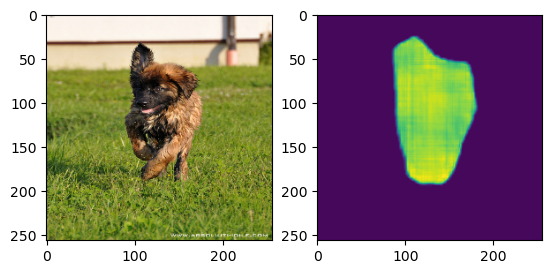

In [38]:
x, y = next(iter(test_class_seg))
classification, decoded = model_test(x)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(unprocess_image(tf.squeeze(x[0])).numpy().astype(int))
axs[1].imshow(unprocess_image(tf.squeeze(decoded[0])).numpy().astype(int))

#### From Scratch

Model: "model_from_scratch"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d_1[0][0]

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 169s 5s/step - loss: 3.9892 - classification_loss: 3.6094 - resizing_loss: 0.3798 - val_loss: 4.0369 - val_classification_loss: 3.6138 - val_resizing_loss: 0.4230
Epoch 2/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 169s 5s/step - loss: 3.8818 - classification_loss: 3.5721 - resizing_loss: 0.3097 - val_loss: 4.0563 - val_classification_loss: 3.6335 - val_resizing_loss: 0.4228
Epoch 3/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 171s 5s/step - loss: 3.8315 - classification_loss: 3.5432 - resizing_loss: 0.2882 - val_loss: 4.1334 - val_classification_loss: 3.7105 - val_resizing_loss: 0.4229
Epoch 4/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 171s 5s/step - loss: 3.7718 - classification_loss: 3.5047 - resizing_loss: 0.2672 - val_loss: 4.2901 - val_classification_loss: 3.8668 - val_resizing_loss: 0.4234
Epoch 5/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 169s 5s/step - loss: 3.7289 - classification_loss: 3.4698 - resizing_loss: 0.2590 - val_loss: 4.3719 - val_classification_loss: 3.9658 - val_resizing_loss: 0.4062
Epoch 6/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 173s 5s/step - loss: 3.6780 - classification_loss: 3.4278 - resizing_loss: 0.2502 - val_loss: 4.1817 - val_classification_loss: 3.8879 - val_resizing_loss: 0.2938
Epoch 7/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 169s 5s/step - loss: 3.6381 - classification_loss: 3.3930 - resizing_loss: 0.2450 - val_loss: 4.4661 - val_classification_loss: 4.1391 - val_resizing_loss: 0.3270
Epoch 8/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 165s 4s/step - loss: 3.5870 - classification_loss: 3.3483 - resizing_loss: 0.2387 - val_loss: 4.4667 - val_classification_loss: 4.0975 - val_resizing_loss: 0.3692
Epoch 9/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 170s 5s/step - loss: 3.5277 - classification_loss: 3.2909 - resizing_loss: 0.2367 - val_loss: 4.3480 - val_classification_loss: 4.0786 - val_resizing_loss: 0.2694
Epoch 10/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 171s 5s/step - loss: 3.4823 - classification_loss: 3.2545 - resizing_loss: 0.2278 - val_loss: 4.6148 - val_classification_loss: 4.3417 - val_resizing_loss: 0.2731
Epoch 11/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 170s 5s/step - loss: 3.4667 - classification_loss: 3.2445 - resizing_loss: 0.2222 - val_loss: 4.1481 - val_classification_loss: 3.9187 - val_resizing_loss: 0.2294
Epoch 12/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 170s 5s/step - loss: 3.4354 - classification_loss: 3.2124 - resizing_loss: 0.2230 - val_loss: 4.0305 - val_classification_loss: 3.8092 - val_resizing_loss: 0.2213
Epoch 13/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 170s 5s/step - loss: 3.3959 - classification_loss: 3.1800 - resizing_loss: 0.2159 - val_loss: 3.7496 - val_classification_loss: 3.5331 - val_resizing_loss: 0.2164
Epoch 14/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 170s 5s/step - loss: 3.3473 - classification_loss: 3.1337 - resizing_loss: 0.2137 - val_loss: 3.9748 - val_classification_loss: 3.7666 - val_resizing_loss: 0.2082
Epoch 15/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


37/37 [==============================] - 170s 5s/step - loss: 3.3454 - classification_loss: 3.1308 - resizing_loss: 0.2147 - val_loss: 3.8543 - val_classification_loss: 3.6526 - val_resizing_loss: 0.2017


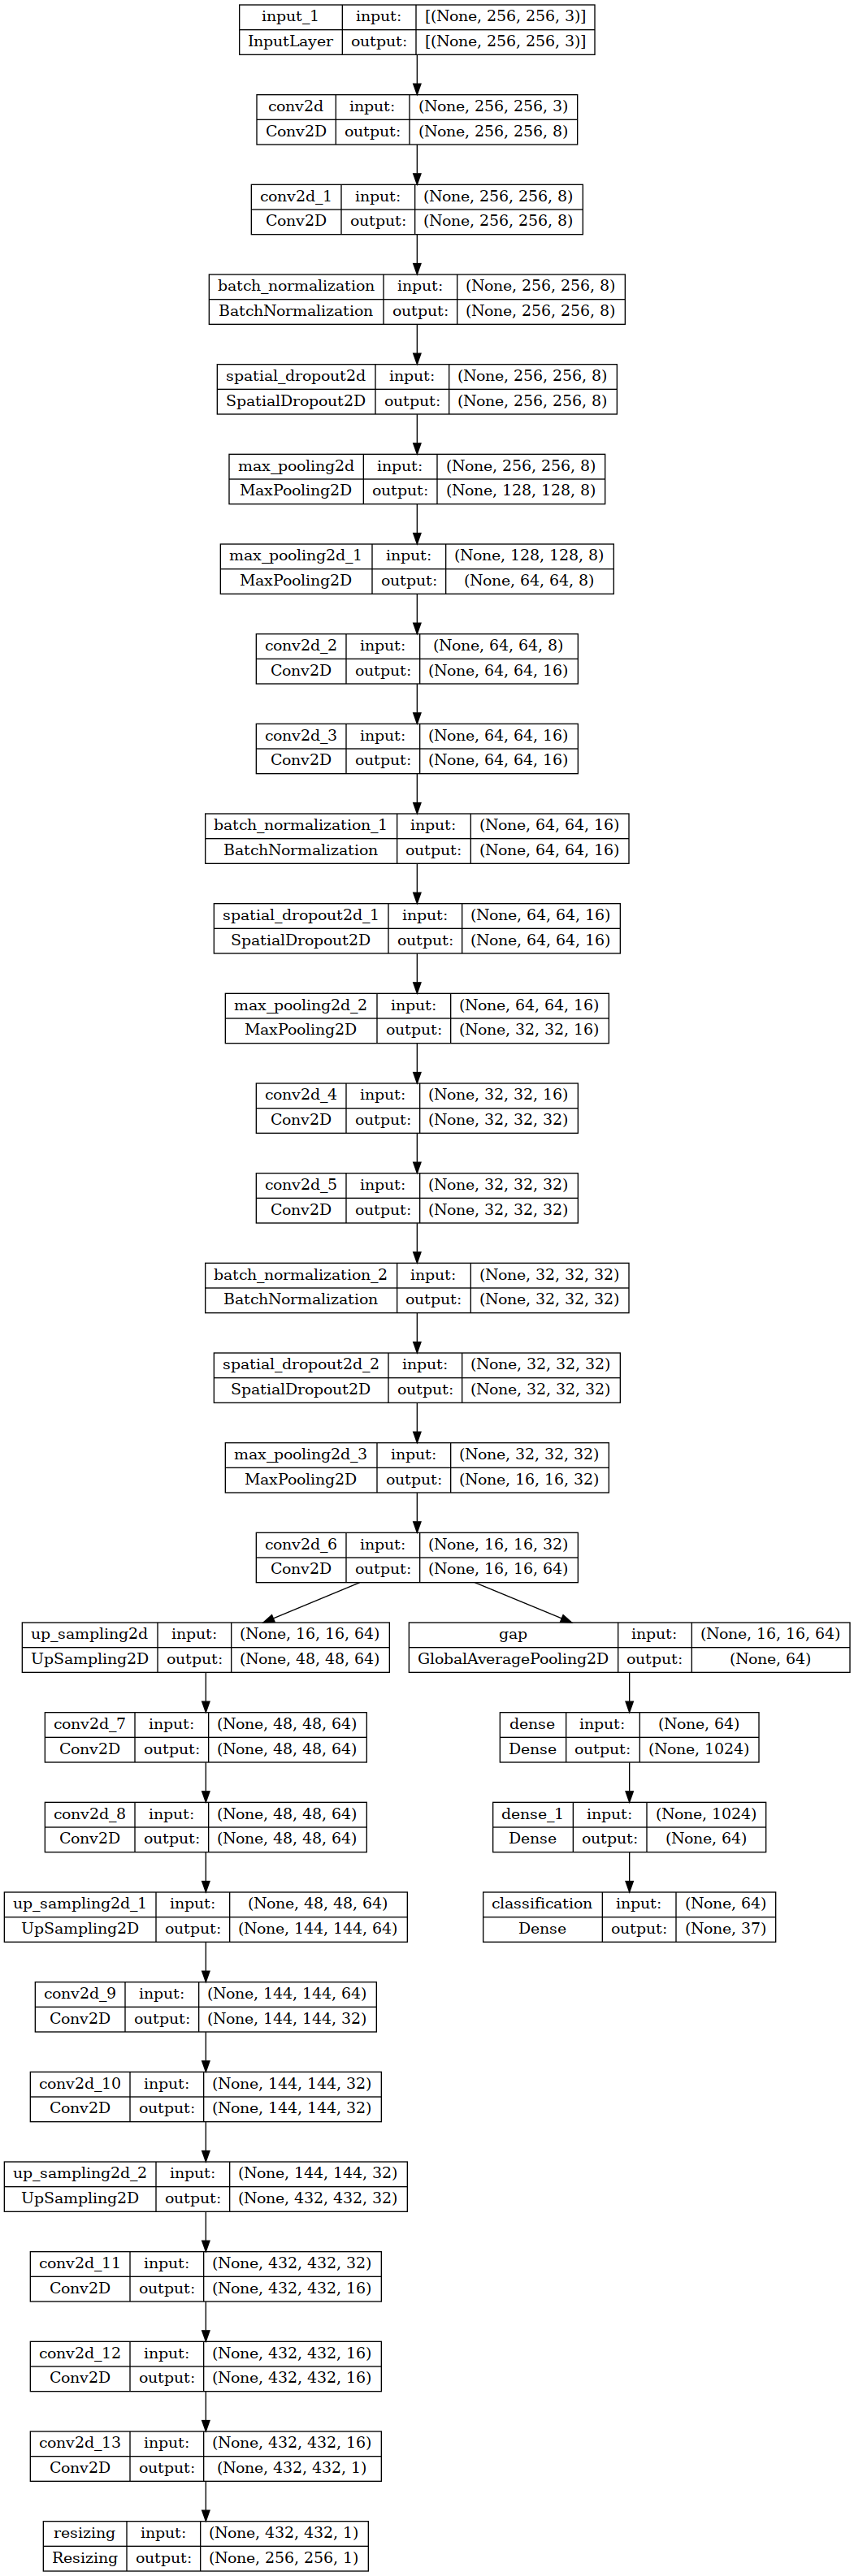

In [8]:
################################
# BACKBONE
################################

# our model, input again, still in an image shape
inputs = keras.Input(shape=(256, 256, 3, ), name='img')
inputs = layers.Input((image_size, image_size, 3))

# run pairs of conv layers, all 3s3 kernels
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
# batch normalisation, before the non-linearity
x = layers.BatchNormalization()(x)
# spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
# than dropping out 20% of the invidual pixels
x = layers.SpatialDropout2D(0.2)(x)
# max pooling, 2x2, which will downsample the image
x = layers.MaxPool2D(pool_size=(2, 2))(x)
# max pooling, 2x2, which will downsample the image
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# rinse and repeat with 2D convs, batch norm, dropout and max pool
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# final conv2d, batch norm and spatial dropout
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.SpatialDropout2D(0.2)(x)

################################
# END OF BACKBONE
################################
end_of_backbone = layers.MaxPool2D(pool_size=(2, 2))(x)


################################
# CLASSIFICATION HEAD
################################
embedding = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(end_of_backbone)
flattened = layers.GlobalAveragePooling2D(name='gap')(embedding)
x = keras.layers.Dense(1024, activation='relu')(flattened)
x = keras.layers.Dense(64, activation='relu')(x)
classification_2 = layers.Dense(37, activation=None, name='classification')(x)


################################
# SEGMENTATION HEAD
################################
x =  layers.UpSampling2D((3, 3))(embedding)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x =  layers.UpSampling2D((3, 3))(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x =  layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# output, 3 channels
x =  layers.Conv2D(1, (1, 1), activation=None, padding='same')(x)
decoded_2 = keras.layers.Resizing(image_size, image_size)(x)







model_test_2 = keras.Model(inputs, outputs=[classification_2, decoded_2],  name='model_from_scratch')



model_test_2.summary()

keras.utils.plot_model(model_test_2, show_shapes=True)

model_test_2.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   keras.losses.MeanAbsoluteError()],
              optimizer='adam')

history = model_test_2.fit(train_class_seg,
          epochs=15,
          validation_data=test_class_seg,
          verbose=True)

keras.utils.plot_model(model_test_2, show_shapes=True)



In [9]:
history.history.keys()

dict_keys(['loss', 'classification_loss', 'resizing_loss', 'val_loss', 'val_classification_loss', 'val_resizing_loss'])

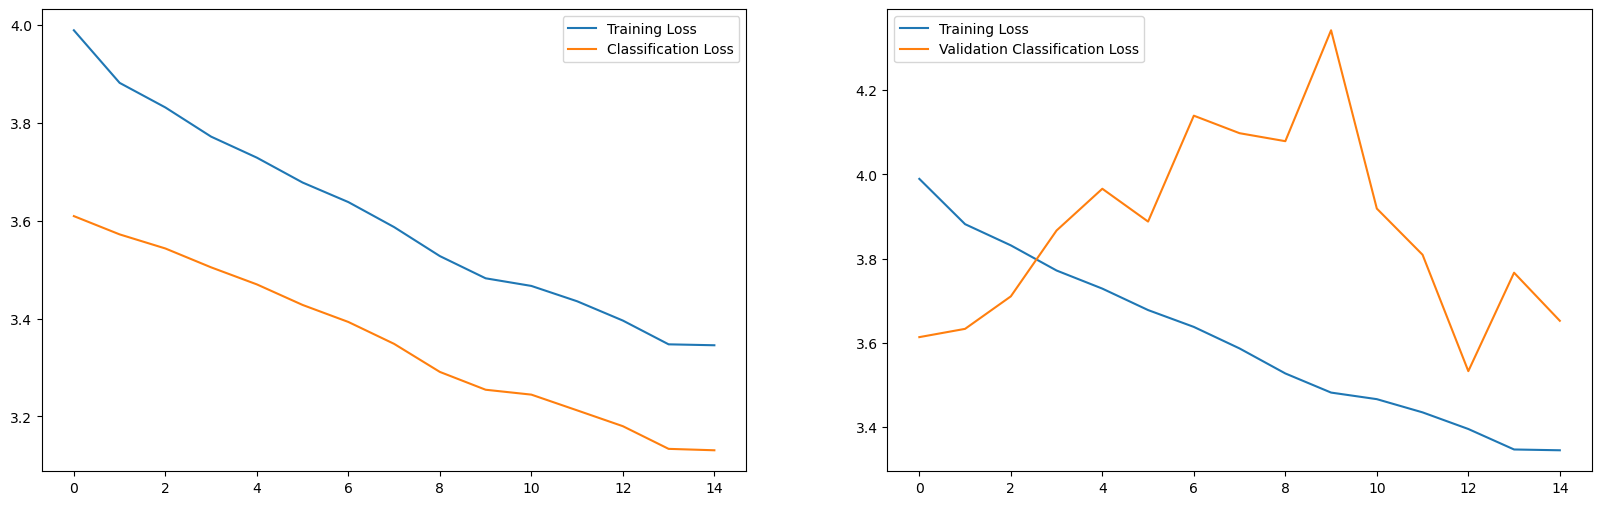

In [10]:
# plot training and validation loss and accuracy
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['classification_loss'], label="Classification Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_classification_loss'], label="Validation Classification Loss")
ax.legend()

# plot confusion matrices and F1 scores
# fig = plt.figure(figsize=[20, 8])    

# ax = fig.add_subplot(1, 2, 1)    
# pred = model_test_2.predict(train_class_seg, verbose=False);
# indexes = tf.argmax(pred, axis=1)
# gt_idx = tf.argmax(test_class_seg, axis=1)

# confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
# sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#         annot=True, fmt='g', ax=ax)
# ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

# ax = fig.add_subplot(1, 2, 2)    
# pred = model_test_2.predict(train_class_seg, verbose=False);
# indexes = tf.argmax(pred, axis=1)
# gt_idx = tf.argmax(test_class_seg, axis=1)

# confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
# sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#         annot=True, fmt='g', ax=ax)
# ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

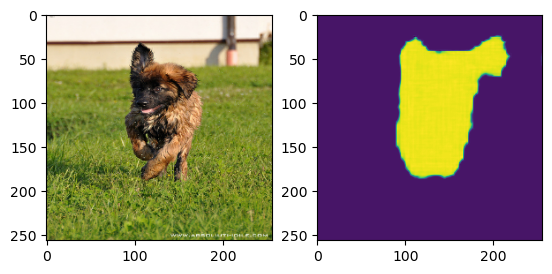

In [11]:
x, y = next(iter(test_class_seg))
classification_2, decoded_2 = model_test_2(x)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(unprocess_image(tf.squeeze(x[0])).numpy().astype(int))
axs[1].imshow(unprocess_image(tf.squeeze(decoded_2[0])).numpy().astype(int))

In [12]:
# # 128 is the current image size 
# # 3 channels

# ################################
# # BACKBONE
# ################################

# # our model, input again, still in an image shape
# inputs = keras.Input(shape=(256, 256, 3, ), name='img')
# inputs = layers.Input((image_size, image_size, 3))

# # run pairs of conv layers, all 3s3 kernels
# x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
# x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
# # batch normalisation, before the non-linearity
# x = layers.BatchNormalization()(x)
# # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
# # than dropping out 20% of the invidual pixels
# x = layers.SpatialDropout2D(0.2)(x)
# # max pooling, 2x2, which will downsample the image
# x = layers.MaxPool2D(pool_size=(2, 2))(x)
# # max pooling, 2x2, which will downsample the image
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # rinse and repeat with 2D convs, batch norm, dropout and max pool
# x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.SpatialDropout2D(0.2)(x)
# x = layers.MaxPool2D(pool_size=(2, 2))(x)

# # final conv2d, batch norm and spatial dropout
# x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.SpatialDropout2D(0.2)(x)

# ################################
# # END OF BACKBONE
# ################################
# end_of_backbone = layers.MaxPool2D(pool_size=(2, 2))(x)



# ################################
# # CLASSIFICATION HEAD
# ################################

# # flatten layer
# # x = layers.Flatten()(end_of_backbone)
# # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
# # in the middle
# x = layers.Dense(256, activation='relu')(end_of_backbone)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(64, activation='relu')(x)
# # the output
# class_output = layers.Dense(37, activation='softmax')(x)

# # use one hot representation for the classification task use sparse_categorical_crossentropy
# # model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='model q2')
# # model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='model q2')



# ################################
# # SEGMENTATION HEAD
# ################################

# # decoder
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(end_of_backbone)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x) # values between 0 or 1  by this 

# # use binary cross entropy for the segmentation task
# # model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='model q2')
# # model_cnn.compile(optimizer='adam', loss=['categorical_crossentropy', 'binary_crossentropy'], metrics=['accuracy'])



# # build the model, and print a summary
# # model_cnn = keras.Model(inputs=inputs, outputs=[class_output, decoded ], name='model_q2_from_scratch')
# # model_cnn.summary()
# # model_cnn.compile(optimizer='adam', metrics=['accuracy'])


# # something_test = model_cnn.fit(train_class_seg, epochs=10, validation_data=test_class_seg)

# # evaluate the model
# # loss, class_loss, seg_loss, class_acc, seg_acc = model_cnn.evaluate(test_class_seg)
# # print('Loss: ', loss)
# # print('Classification Loss: ', class_loss)
# # print('Segmentation Loss: ', seg_loss)
# # print('Classification Accuracy: ', class_acc)
# # print('Segmentation Accuracy: ', seg_acc)

# # predict on the test set
# # class_pred , seg_pred = model_cnn.predict(test_class_seg)
# # print(class_pred.shape)
# # print(seg_pred.shape)

# # history = model_cnn.fit(decoded,
# #                         epochs=12,
# #                         validation_data=test_class_seg,
# #                         verbose=False)


# model_test_2 = keras.Model(inputs, [class_output, decoded])

# model_test_2.summary()

# model_test_2.compile(loss=[keras.losses.CategoricalCrossentropy(from_logits=False),
#                            keras.losses.BinaryCrossentropy()],
#                      optimizer='adam')

# # Convert train_class_seg and test_class_seg to arrays
# train_class_seg_array = []
# test_class_seg_array = []

# for batch in train_class_seg.as_numpy_iterator():
#     train_class_seg_array.append(batch)

# for batch in test_class_seg.as_numpy_iterator():
#     test_class_seg_array.append(batch)

# train_class_seg_array = np.concatenate(train_class_seg_array)
# test_class_seg_array = np.concatenate(test_class_seg_array)

# # One-hot encode the labels
# train_class_seg_encoded = tf.keras.utils.to_categorical(train_class_seg_array, num_classes=37)
# test_class_seg_encoded = tf.keras.utils.to_categorical(test_class_seg_array, num_classes=37)

# history = model_test_2.fit(train_class_seg_encoded,
#                            epochs=10,
#                            validation_data=(test_class_seg_encoded, test_class_seg_encoded),
#                            verbose=True)
